In [29]:
import geopandas as gpd
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from bikescience import sp_grid

base_folder = '../../../data/sao-paulo/'

Tracts

In [4]:
tracts = gpd.read_file(base_folder + 'ibge/sectors/33SEE250GC_SIR.shp')
tracts.head()

ID       CD_GEOCODI    TIPO   CD_GEOCODS NM_SUBDIST CD_GEOCODD  \
0  98237.0  354100005000009  URBANO  35410000500       None  354100005   
1  98232.0  354100005000004  URBANO  35410000500       None  354100005   
2  98230.0  354100005000002  URBANO  35410000500       None  354100005   
3  98229.0  354100005000001  URBANO  35410000500       None  354100005   
4  98231.0  354100005000003  URBANO  35410000500       None  354100005   

     NM_DISTRIT CD_GEOCODM    NM_MUNICIP NM_MICRO                     NM_MESO  \
0  PRAIA GRANDE    3541000  PRAIA GRANDE   SANTOS  METROPOLITANA DE SÃO PAULO   
1  PRAIA GRANDE    3541000  PRAIA GRANDE   SANTOS  METROPOLITANA DE SÃO PAULO   
2  PRAIA GRANDE    3541000  PRAIA GRANDE   SANTOS  METROPOLITANA DE SÃO PAULO   
3  PRAIA GRANDE    3541000  PRAIA GRANDE   SANTOS  METROPOLITANA DE SÃO PAULO   
4  PRAIA GRANDE    3541000  PRAIA GRANDE   SANTOS  METROPOLITANA DE SÃO PAULO   

     CD_GEOCODB  NM_BAIRRO  ID1  \
0  354100005001  Boqueirão    1   
1  354100005001  Boqueirão    2   
2  354100005001  Boqueirão    3   
3  354100005001  Boqueirão    4   
4  354100005001  Boqueirão    5   

                                            geometry  
0  POLYGON ((-46.410239 -24.011028, -46.411694999...  
1  POLYGON ((-46.416055 -24.002446, -46.415983999...  
2  POLYGON ((-46.412132 -24.007921, -46.412442 -2...  
3  POLYGON ((-46.411342 -24.00552, -46.411965 -24...  
4  POLYGON ((-46.413264 -24.005136, -46.414838 -2...

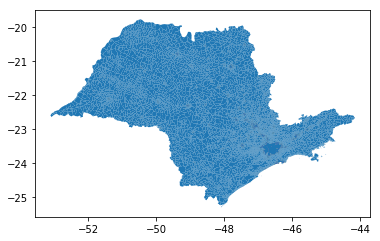

In [5]:
tracts.plot()
plt.show()

Only São Paulo city

In [6]:
tracts.NM_MUNICIP.value_counts().head(10)

SÃO PAULO                18953
CAMPINAS                  1749
GUARULHOS                 1748
SÃO BERNARDO DO CAMPO     1222
SANTO ANDRÉ               1194
SÃO JOSÉ DOS CAMPOS       1074
RIBEIRÃO PRETO            1004
OSASCO                     943
PIRACICABA                 718
SOROCABA                   684
Name: NM_MUNICIP, dtype: int64

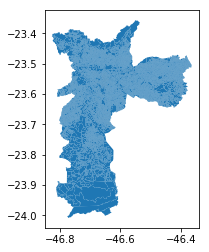

In [9]:
sp_tracts = tracts[tracts.NM_MUNICIP == 'SÃO PAULO']
sp_tracts.plot()
plt.show()

Selected census features

In [38]:
census_features = pd.read_csv(base_folder + 'training-sets/processing/ibge-census.csv')
census_features.head()

Cod_setor  V001_basic  V002_basic  V003_basic  V004_basic  \
0  355030801000001       266.0       800.0        3.01        2.32   
1  355030801000002       306.0       913.0        2.98        2.09   
2  355030801000003       189.0       625.0        3.31        3.08   
3  355030801000004       181.0       572.0        3.16        2.26   
4  355030801000005       240.0       754.0        3.14        2.35   

   V005_basic  V006_basic  V007_basic  V008_basic  V009_basic  ...  \
0     2091.32  8532451.78     2164.55  8673276.78     1227.41  ...   
1     1650.09  3983441.31     1717.44  4030519.99     1045.78  ...   
2     1280.43  5474593.06     2349.53  7553913.02      902.97  ...   
3     1119.59  3572955.10     1859.13  4567289.50      869.09  ...   
4     1416.90  2240207.58     1581.66  2240109.39      917.71  ...   

   V045_people_inc  V046_people_inc  V047_people_inc  V048_people_inc  \
0              2.0             66.0             95.0             45.0   
1              4.0             97.0            104.0             35.0   
2              1.0             20.0             54.0             20.0   
3              2.0             18.0             60.0             21.0   
4              2.0             68.0             86.0             27.0   

   V049_people_inc  V050_people_inc  V051_people_inc  V052_people_inc  \
0             29.0             26.0              2.0              0.0   
1             23.0             25.0              0.0              2.0   
2             29.0              9.0              1.0              2.0   
3             14.0             12.0              1.0              0.0   
4             23.0             12.0              2.0              0.0   

   V053_people_inc  V054_people_inc  
0              2.0            132.0  
1              2.0            154.0  
2              0.0            160.0  
3              0.0            137.0  
4              0.0            138.0  

[5 rows x 137 columns]

In [39]:
socio_columns = census_features.columns.tolist()
socio_columns.remove('Cod_setor')
for c in socio_columns:
    if not census_features[c].dtype in [np.dtype('float'), np.dtype('int')]:
        print()
        print(c, census_features[c].dtype)
        display(census_features[c].describe())

Intersecting grid cells and census tracts
* Taking indicators proportionally to the intersected area

In [40]:
tracts.CD_GEOCODI = tracts.CD_GEOCODI.astype(int)
census_merge = gpd.GeoDataFrame(tracts.merge(census_features, left_on='CD_GEOCODI', right_on='Cod_setor'))

grid = sp_grid.create(n=40, west_offset=-.1, east_offset=.01, north_offset=.01, south_offset=-.1)
proportional = gpd.sjoin(grid.geodataframe(), census_merge, op='intersects') \
               .merge(census_merge[['CD_GEOCODI', 'geometry']], on='CD_GEOCODI')
proportional.rename(columns={'geometry_x': 'geometry_cell', 'geometry_y': 'geometry_tract'}, inplace=True)

proportional['geometry_intersection'] = proportional.apply(
        lambda row: row.geometry_cell.intersection(row.geometry_tract),
        axis=1)
proportional['proportion'] = \
        gpd.GeoSeries(proportional.geometry_intersection).area / gpd.GeoSeries(proportional.geometry_tract).area

proportional.proportion.head()

0    0.020156
1    0.527795
2    0.485578
3    0.417405
4    0.551516
Name: proportion, dtype: float64

In [41]:
proportional.proportion.describe()

count    9865.000000
mean        0.288505
std         0.303871
min         0.000000
25%         0.041982
50%         0.171491
75%         0.450104
max         1.000000
Name: proportion, dtype: float64

In [42]:
aggs = {}
for c in socio_columns:
    proportional[c] = proportional['proportion'] * proportional[c]
    aggs[c] = ['min', 'max', 'mean', 'std']
    
per_cell = proportional.groupby(['i', 'j'], as_index=False).agg(aggs)
per_cell.columns = ['_'.join(col).strip() for col in per_cell.columns.values]
per_cell.rename(columns={'i_': 'i', 'j_': 'j'}, inplace=True)
per_cell.head()

i  j  V053_acc_inc_min  V053_acc_inc_max  V053_acc_inc_mean  \
0  0  0               0.0          0.000000           0.000000   
1  0  1               0.0          0.403302           0.050413   
2  0  2               0.0          0.000389           0.000078   
3  0  3               0.0          0.000000           0.000000   
4  0  4               0.0          0.000000           0.000000   

   V053_acc_inc_std  V026_people_inc_min  V026_people_inc_max  \
0          0.000000             1.068250            27.677973   
1          0.142589             0.854973            27.973144   
2          0.000174             0.021772            14.259916   
3          0.000000             0.356549             3.026350   
4          0.000000             1.822008             2.194179   

   V026_people_inc_mean  V026_people_inc_std  ...  V109_acc2_mean  \
0             13.486843            10.402713  ...       40.448529   
1             12.793426            10.853405  ...       40.444988   
2              6.663984             6.619431  ...       20.301142   
3              1.691449             1.887834  ...        4.474919   
4              2.008093             0.263165  ...        6.602676   

   V109_acc2_std  V004_min   V004_max  V004_mean   V004_std  V001_acc1.1_min  \
0      28.981541       0.0  26.888737   4.951142  10.097598         1.632609   
1      33.687934       0.0   3.390378   0.423797   1.198680         2.648332   
2      19.035815       0.0   0.000000   0.000000   0.000000         0.031492   
3       5.135540       0.0   0.000000   0.000000   0.000000         1.104433   
4       2.435698       0.0   0.000000   0.000000   0.000000         3.318657   

   V001_acc1.1_max  V001_acc1.1_mean  V001_acc1.1_std  
0        59.240574         32.265378        25.399564  
1        42.751409         24.279699        15.130845  
2        70.858617         26.002845        30.737965  
3         5.512280          3.308356         3.116818  
4         6.969746          5.144201         2.581710  

[5 rows x 546 columns]

In [43]:
per_cell.to_csv(base_folder + 'training-sets/processing/cells-and-census.csv', index=False)